Based on: https://automating-gis-processes.github.io/CSC18/lessons/L6/clipping-raster.html

In [99]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
import pycrs

Define the directory to open the image from and the name of the final clip to be saved

In [3]:
fp = r"../data/Qro_2020-09-12.tif"

out_tif = r"img/clip.tif"

data = rasterio.open(fp)

Display the entire image

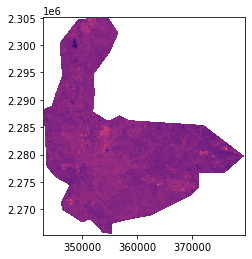

In [102]:
show((data, 1), cmap='magma')

Define the region to clip the image to (LAT, LON)

In [103]:
# WGS84 coordinates
In [13]: minx, miny = -100.27, 20.56

In [14]: maxx, maxy = -100.26, 20.57

In [15]: bbox = box(minx, miny, maxx, maxy)

Insert the bbox into a GeoDataFrame

In [104]:
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))

Re-project into the same coordinate system as the raster data

In [105]:
geo = geo.to_crs(crs=data.crs.data)

Next we need to get the coordinates of the geometry in such a format that rasterio wants them. This can be conducted easily with following function

In [106]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

Get the geometry coordinates by using the function.

In [107]:
coords = getFeatures(geo)
print(coords)

[{'type': 'Polygon', 'coordinates': [[[368661.74863416963, 2273960.1042842744], [368670.30044586904, 2275066.978633015], [367627.87230572914, 2275075.0663786693], [367619.2525748232, 2273968.1887951014], [368661.74863416963, 2273960.1042842744]]]}]


Okey, so rasterio wants to have the coordinates of the Polygon in this kind of format.

Now we are ready to clip the raster with the polygon using the coords variable that we just created. Clipping the raster can be done easily with the mask function that we imported in the beginning from rasterio, and specifying clip=True.

In [108]:
out_img, out_transform = mask(dataset=data, shapes=coords, crop=True)

Next, we need to modify the metadata. Let’s start by copying the metadata from the original data file.

In [109]:
out_meta = data.meta.copy()
print(out_meta)

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 3695, 'height': 3973, 'count': 1, 'crs': CRS.from_epsg(32614), 'transform': Affine(10.0, 0.0, 342780.9405299558,
       0.0, -10.0, 2305064.6405019495)}


Next we need to parse the EPSG value from the CRS so that we can create a Proj4 string using PyCRS library (to ensure that the projection information is saved correctly).

In [110]:
epsg_code = int(data.crs.data['init'][5:])
print(epsg_code)

32614


Now we need to update the metadata with new dimensions, transform (affine) and CRS (as Proj4 text)

In [111]:
out_meta.update({"driver": "GTiff",
                 "height": out_img.shape[1],
                 "width": out_img.shape[2],
                 "transform": out_transform,
                 "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()})


Finally, we can save the clipped raster to disk with following command.

In [95]:
with rasterio.open(out_tif, "w", **out_meta) as dest:
    dest.write(out_img)

Let’s still check that the result is correct by plotting our new clipped raster.

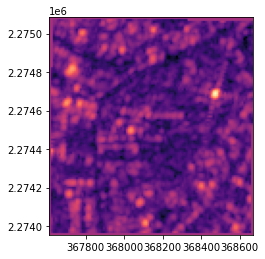

In [96]:
clipped = rasterio.open(out_tif)
show((clipped, 1), cmap='magma')

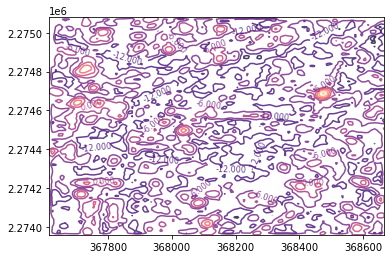

In [98]:
clipped = rasterio.open(out_tif)
show((clipped, 1), cmap='magma', contour=True)